In [8]:
# Import necessary libraries
from google.colab import drive
import tarfile
import os
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import Adam

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Path to the dataset archive on Google Drive
archive_path = '/content/drive/MyDrive/BreaKHis_v1.tar.gz'

In [4]:
# Directory where the dataset will be extracted
extract_dir = '/content/BreaKHis_dataset'

In [5]:
# Create a directory if it does not exist
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

In [6]:
# Extract the dataset
with tarfile.open(archive_path, 'r:gz') as archive:
    archive.extractall(path=extract_dir)

print('Extraction completed!')

Extraction completed!


In [7]:
# Path to the dataset directory
base_dir = '/content/BreaKHis_dataset/BreaKHis_v1/histology_slides/breast'

In [9]:
# Prepare data generators
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # using 20% of the data for validation
)

train_it = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    class_mode='binary',  # or 'categorical' if multi-class
    batch_size=32,
    subset='training'
)

val_it = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    class_mode='binary',  # or 'categorical' if multi-class
    batch_size=32,
    subset='validation'
)

Found 6328 images belonging to 2 classes.
Found 1581 images belonging to 2 classes.


In [10]:
# CNN Model
def build_cnn_model():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # or 'softmax' for multi-class
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

cnn_model = build_cnn_model()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
# VGG Model
def build_vgg_model():
    base_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze layers
    x = Flatten()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

vgg_model = build_vgg_model()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [12]:
# ResNet Model
def build_resnet_model():
    base_model = ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    base_model.trainable = False
    x = Flatten()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

resnet_model = build_resnet_model()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [13]:
# Train models
def train_model(model, train_it, val_it):
    history = model.fit(
        train_it,
        steps_per_epoch=train_it.samples // train_it.batch_size,
        validation_data=val_it,
        validation_steps=val_it.samples // val_it.batch_size,
        epochs=5
    )
    return history

In [14]:
cnn_history = train_model(cnn_model, train_it, val_it)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


197/197 ━━━━━━━━━━━━━━━━━━━━ 111s 512ms/step - accuracy: 0.7299 - loss: 0.7937 - val_accuracy: 0.7997 - val_loss: 0.4623
Epoch 2/5
  1/197 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.8438 - loss: 0.4779

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8438 - loss: 0.4779 - val_accuracy: 0.7692 - val_loss: 0.4776
Epoch 3/5
197/197 ━━━━━━━━━━━━━━━━━━━━ 96s 474ms/step - accuracy: 0.7991 - loss: 0.4798 - val_accuracy: 0.7915 - val_loss: 0.4645
Epoch 4/5
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step - accuracy: 0.8438 - loss: 0.4345 - val_accuracy: 0.7692 - val_loss: 0.3983
Epoch 5/5
197/197 ━━━━━━━━━━━━━━━━━━━━ 96s 474ms/step - accuracy: 0.8151 - loss: 0.4459 - val_accuracy: 0.8335 - val_loss: 0.3866


In [15]:
vgg_history = train_model(vgg_model, train_it, val_it)

Epoch 1/5
197/197 ━━━━━━━━━━━━━━━━━━━━ 118s 519ms/step - accuracy: 0.7083 - loss: 0.9263 - val_accuracy: 0.6518 - val_loss: 0.6357
Epoch 2/5
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8750 - loss: 0.3334 - val_accuracy: 0.7692 - val_loss: 0.4562
Epoch 3/5
197/197 ━━━━━━━━━━━━━━━━━━━━ 96s 476ms/step - accuracy: 0.8303 - loss: 0.3937 - val_accuracy: 0.6990 - val_loss: 0.7550
Epoch 4/5
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step - accuracy: 0.7812 - loss: 0.4362 - val_accuracy: 0.7692 - val_loss: 0.7025
Epoch 5/5
197/197 ━━━━━━━━━━━━━━━━━━━━ 96s 474ms/step - accuracy: 0.8451 - loss: 0.3609 - val_accuracy: 0.7015 - val_loss: 0.6674


In [16]:
resnet_history = train_model(resnet_model, train_it, val_it)

Epoch 1/5
197/197 ━━━━━━━━━━━━━━━━━━━━ 114s 507ms/step - accuracy: 0.6198 - loss: 2.0335 - val_accuracy: 0.6862 - val_loss: 0.6602
Epoch 2/5
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8750 - loss: 0.4554 - val_accuracy: 0.6923 - val_loss: 0.6632
Epoch 3/5
197/197 ━━━━━━━━━━━━━━━━━━━━ 96s 475ms/step - accuracy: 0.6943 - loss: 0.6234 - val_accuracy: 0.6875 - val_loss: 0.6203
Epoch 4/5
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step - accuracy: 0.7812 - loss: 0.5889 - val_accuracy: 0.5385 - val_loss: 0.7791
Epoch 5/5
197/197 ━━━━━━━━━━━━━━━━━━━━ 96s 473ms/step - accuracy: 0.7014 - loss: 0.6231 - val_accuracy: 0.6862 - val_loss: 0.6224


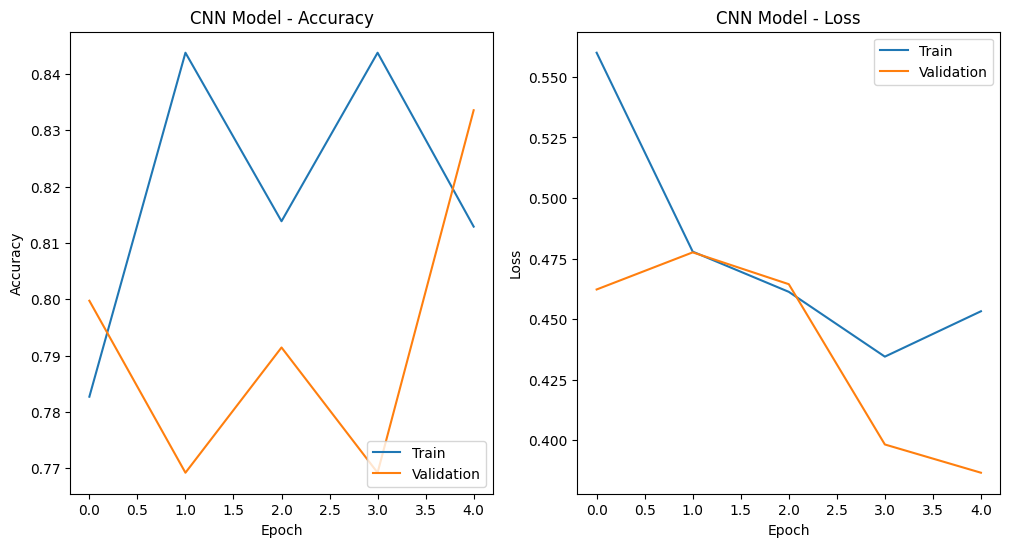

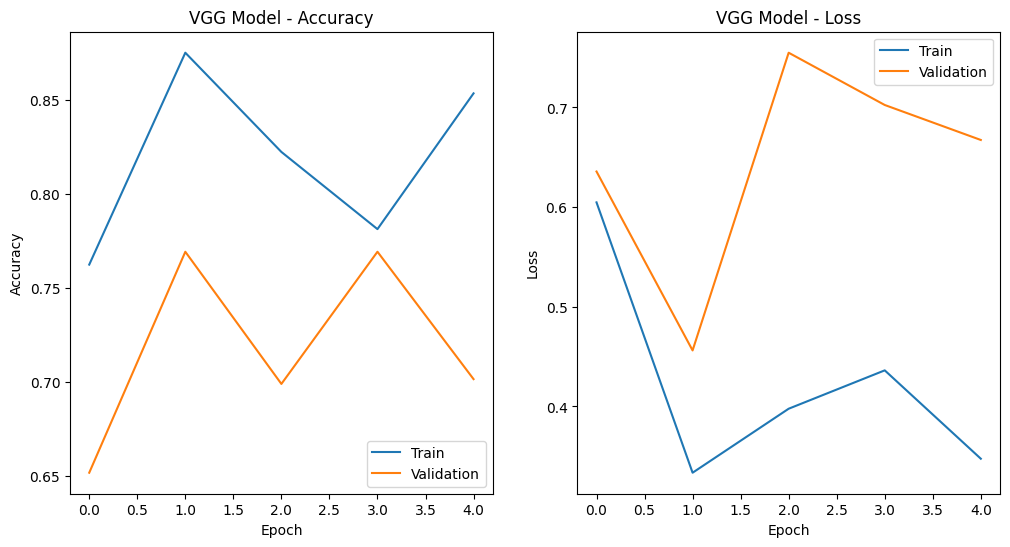

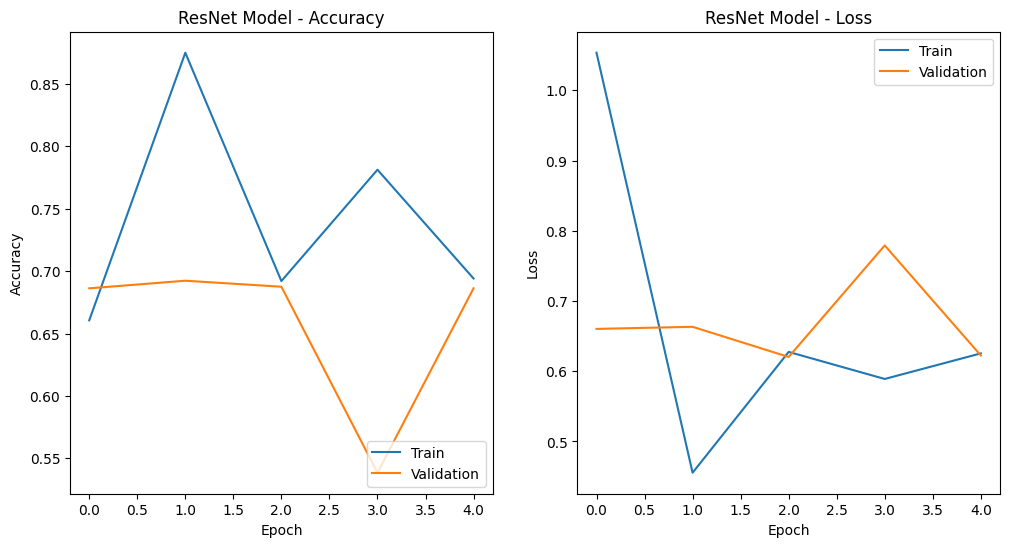

In [17]:
# Plotting function
def plot_model_history(history, title='Model Accuracy and Loss'):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train')
    plt.plot(epochs_range, val_acc, label='Validation')
    plt.title(title + ' - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train')
    plt.plot(epochs_range, val_loss, label='Validation')
    plt.title(title + ' - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.show()

plot_model_history(cnn_history, 'CNN Model')
plot_model_history(vgg_history, 'VGG Model')
plot_model_history(resnet_history, 'ResNet Model')

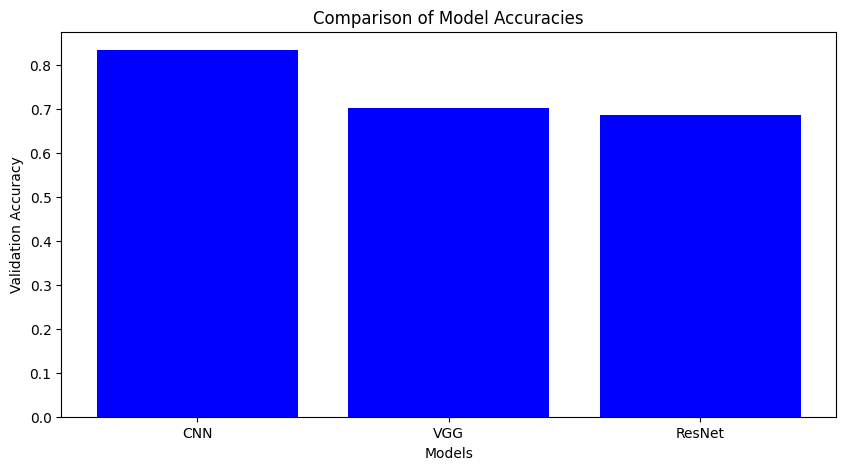

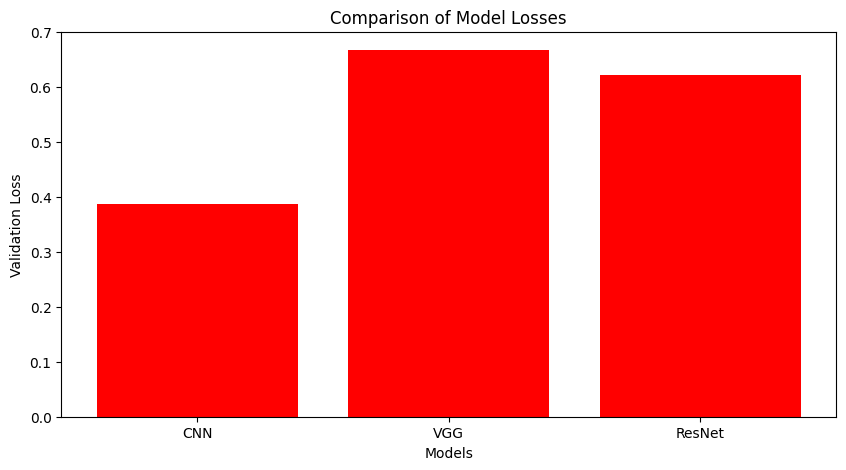

In [18]:
def compare_models(histories, model_names):
    accuracies = [h.history['val_accuracy'][-1] for h in histories]
    losses = [h.history['val_loss'][-1] for h in histories]

    # Accuracy comparison
    plt.figure(figsize=(10, 5))
    plt.bar(model_names, accuracies, color='blue')
    plt.xlabel('Models')
    plt.ylabel('Validation Accuracy')
    plt.title('Comparison of Model Accuracies')
    plt.show()

    # Loss comparison
    plt.figure(figsize=(10, 5))
    plt.bar(model_names, losses, color='red')
    plt.xlabel('Models')
    plt.ylabel('Validation Loss')
    plt.title('Comparison of Model Losses')
    plt.show()

# Call the function with the histories and model names
compare_models([cnn_history, vgg_history, resnet_history], ['CNN', 'VGG', 'ResNet'])

In [19]:
from tensorflow.keras.layers import Input, concatenate, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Conv2D, MaxPooling2D

# Define function to create base CNN model
def build_cnn_features(input_tensor):
    x = Conv2D(32, (3,3), activation='relu')(input_tensor)
    x = MaxPooling2D(2, 2)(x)
    x = Conv2D(64, (3,3), activation='relu')(x)
    x = MaxPooling2D(2, 2)(x)
    x = Conv2D(128, (3,3), activation='relu')(x)
    x = MaxPooling2D(2, 2)(x)
    x = Flatten()(x)
    return x

# Define function to create base VGG model
def build_vgg_features(input_tensor):
    base_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet', input_tensor=input_tensor)
    base_model.trainable = False
    x = Flatten()(base_model.output)
    return x

# Input tensor for both models
input_tensor = Input(shape=(224, 224, 3))

# Building features for both models
cnn_features = build_cnn_features(input_tensor)
vgg_features = build_vgg_features(input_tensor)

# Hybrid Model 1: CNN + VGG
x1 = Dense(512, activation='relu')(cnn_features)
combined_features_1 = concatenate([x1, vgg_features])
final_output_1 = Dense(1, activation='sigmoid')(combined_features_1)  # Assuming binary classification
hybrid_model_1 = Model(inputs=input_tensor, outputs=final_output_1)

# Hybrid Model 2: VGG + CNN
x2 = Dense(512, activation='relu')(vgg_features)
combined_features_2 = concatenate([x2, cnn_features])
final_output_2 = Dense(1, activation='sigmoid')(combined_features_2)  # Assuming binary classification
hybrid_model_2 = Model(inputs=input_tensor, outputs=final_output_2)

# Compile both models
hybrid_model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
hybrid_model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# You can train these models using the same function as defined earlier


In [20]:
def train_hybrid_model(model, train_it, val_it):
    history = model.fit(
        train_it,
        steps_per_epoch=train_it.samples // train_it.batch_size,
        validation_data=val_it,
        validation_steps=val_it.samples // val_it.batch_size,
        epochs=5
    )
    return history

In [21]:
hybrid_history = train_hybrid_model(hybrid_model_1, train_it, val_it)
hybrid_history_2 = train_hybrid_model(hybrid_model_2, train_it, val_it)

Epoch 1/5
197/197 ━━━━━━━━━━━━━━━━━━━━ 103s 491ms/step - accuracy: 0.7478 - loss: 0.6077 - val_accuracy: 0.7742 - val_loss: 0.5710
Epoch 2/5
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9062 - loss: 0.2786 - val_accuracy: 0.7692 - val_loss: 0.3710
Epoch 3/5
197/197 ━━━━━━━━━━━━━━━━━━━━ 96s 475ms/step - accuracy: 0.8485 - loss: 0.3359 - val_accuracy: 0.7742 - val_loss: 0.5704
Epoch 4/5
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step - accuracy: 0.8438 - loss: 0.3618 - val_accuracy: 0.7692 - val_loss: 0.7707
Epoch 5/5
197/197 ━━━━━━━━━━━━━━━━━━━━ 96s 475ms/step - accuracy: 0.9123 - loss: 0.2234 - val_accuracy: 0.7966 - val_loss: 0.5070
Epoch 1/5
197/197 ━━━━━━━━━━━━━━━━━━━━ 105s 501ms/step - accuracy: 0.8308 - loss: 0.4234 - val_accuracy: 0.7710 - val_loss: 0.4935
Epoch 2/5
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8438 - loss: 0.3234 - val_accuracy: 0.8462 - val_loss: 0.2764
Epoch 3/5
197/197 ━━━━━━━━━━━━━━━━━━━━ 97s 476ms/step - accuracy: 0.8975 - loss: 0.2582 - val_a

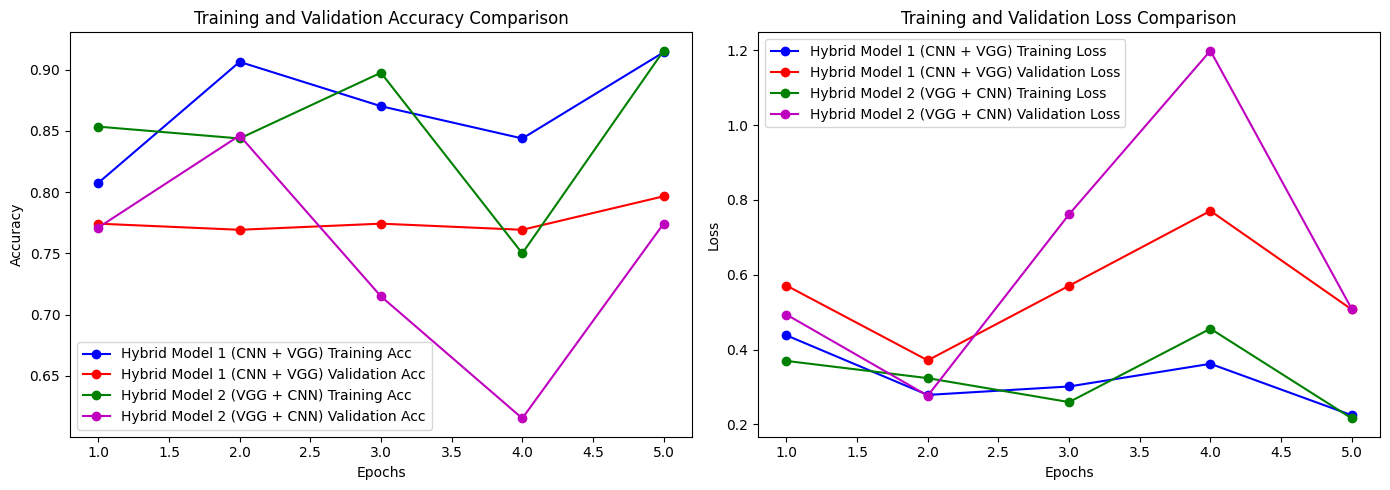

In [22]:
import matplotlib.pyplot as plt

def plot_model_performance(history1, history2, title1='Hybrid Model 1 (CNN + VGG)', title2='Hybrid Model 2 (VGG + CNN)'):
    epochs = range(1, len(history1.history['accuracy']) + 1)

    # Plot accuracy
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history1.history['accuracy'], 'bo-', label=f'{title1} Training Acc')
    plt.plot(epochs, history1.history['val_accuracy'], 'ro-', label=f'{title1} Validation Acc')
    plt.plot(epochs, history2.history['accuracy'], 'go-', label=f'{title2} Training Acc')
    plt.plot(epochs, history2.history['val_accuracy'], 'mo-', label=f'{title2} Validation Acc')
    plt.title('Training and Validation Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history1.history['loss'], 'bo-', label=f'{title1} Training Loss')
    plt.plot(epochs, history1.history['val_loss'], 'ro-', label=f'{title1} Validation Loss')
    plt.plot(epochs, history2.history['loss'], 'go-', label=f'{title2} Training Loss')
    plt.plot(epochs, history2.history['val_loss'], 'mo-', label=f'{title2} Validation Loss')
    plt.title('Training and Validation Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Assuming 'hybrid_history' and 'hybrid_history_2' are the variables storing the training histories
plot_model_performance(hybrid_history, hybrid_history_2)

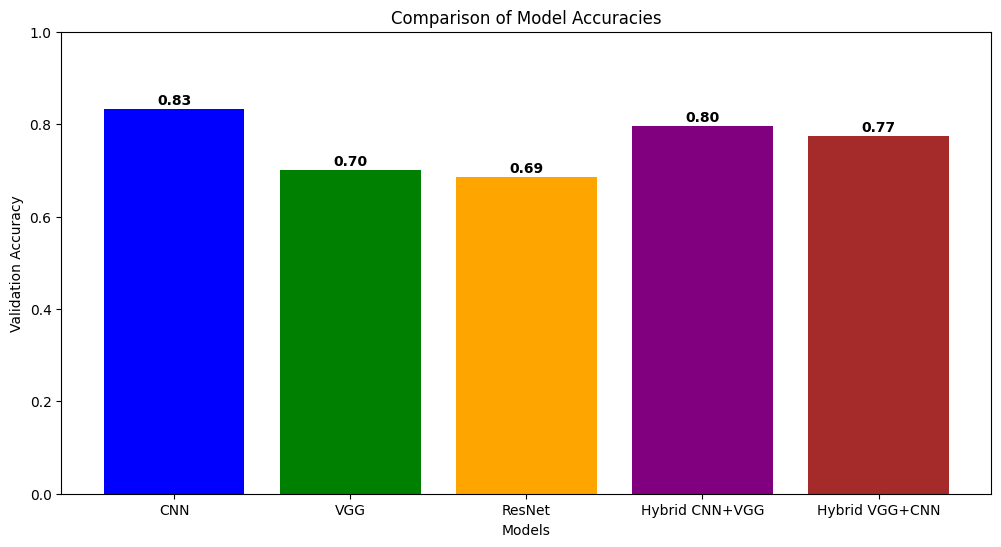

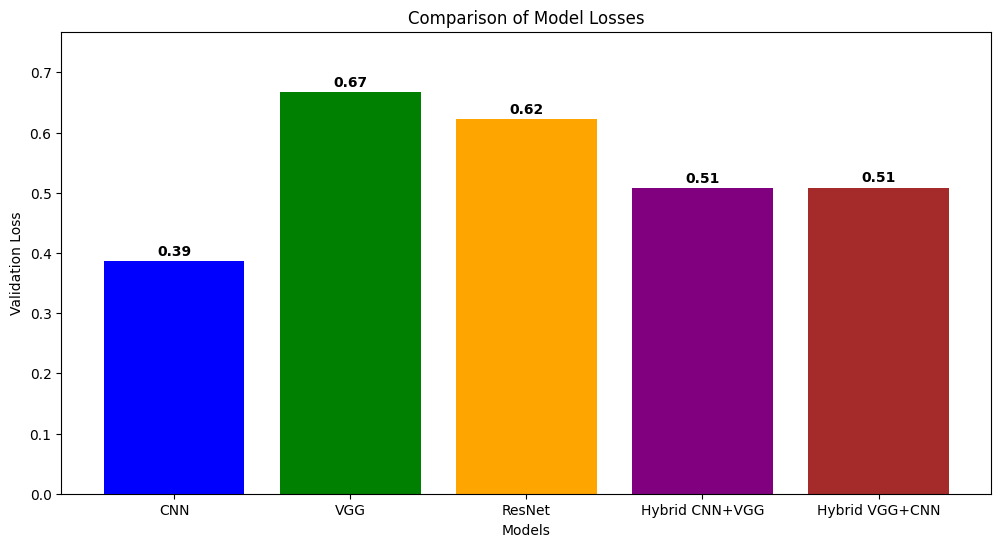

In [23]:
import matplotlib.pyplot as plt

def compare_models(histories, model_names):
    accuracies = [h.history['val_accuracy'][-1] for h in histories]
    losses = [h.history['val_loss'][-1] for h in histories]

    # Colors for the models
    colors = ['blue', 'green', 'orange', 'purple', 'brown']  # Add more colors if needed

    # Accuracy comparison
    plt.figure(figsize=(12, 6))
    plt.bar(model_names, accuracies, color=colors[:len(model_names)])
    plt.xlabel('Models')
    plt.ylabel('Validation Accuracy')
    plt.title('Comparison of Model Accuracies')
    for i, v in enumerate(accuracies):
        plt.text(i, v + 0.01, f"{v:.2f}", ha='center', color='black', fontweight='bold')
    plt.ylim([0, 1])  # Adjust as necessary based on your accuracies
    plt.show()

    # Loss comparison
    plt.figure(figsize=(12, 6))
    plt.bar(model_names, losses, color=colors[:len(model_names)])
    plt.xlabel('Models')
    plt.ylabel('Validation Loss')
    plt.title('Comparison of Model Losses')
    for i, v in enumerate(losses):
        plt.text(i, v + 0.01, f"{v:.2f}", ha='center', color='black', fontweight='bold')
    plt.ylim([0, max(losses) + 0.1])  # Adjust as necessary based on your losses
    plt.show()

# Include the hybrid models in the list for comparison
compare_models(
    [cnn_history, vgg_history, resnet_history, hybrid_history, hybrid_history_2],
    ['CNN', 'VGG', 'ResNet', 'Hybrid CNN+VGG', 'Hybrid VGG+CNN']
)